In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import PowerNorm
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable


import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models


In [3]:
plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 15
plt.rc('legend',fontsize=15) # using a size in points

In [4]:
mass_example = np.vstack(np.load("../../../data/MW-analog/meta_data_psi4/models.npz")["mass"])
red_example = np.vstack(np.load("../../../data/MW-analog/meta_data_psi4/models.npz")["redshift"])
halo_masses = np.linspace(8,12,100) # just for the model


In [15]:
def simple_plot(theta, model_color, model_label=None, mock=True, redshift=False, comparison=False, legend=True,  save_file=None):

    stellar_example = jsm_SHMR.general(theta, mass_example, red_example, 1)
    theta_det = theta[:2] + [0, 0] + theta[4:]

    fig, ax = plt.subplots(figsize=(8, 8))

    if model_label!=None:
        ax.set_title("$\\vec{\\theta}_{\mathrm{fid}}$: " + model_label, fontsize=15)

    if redshift==True:
        z_max = 7
        z_array = np.arange(z_max)

        cmap = plt.get_cmap('RdBu_r')  # You can choose a different colormap
        colors = cmap(np.linspace(0, 1, z_array.shape[0]))
        custom_cmap = ListedColormap(colors)

        sigma = theta[2] + theta[3] * (halo_masses - 12)
        sigma[sigma < 0] = 0.0

        deterministic_early = jsm_SHMR.general(theta_det, halo_masses, z_max, Nsamples=1)
        deterministic_presentday = jsm_SHMR.general(theta_det, halo_masses, 0, Nsamples=1)

        if deterministic_early[0] > deterministic_presentday[0]:
            ax.fill_between(halo_masses, deterministic_early + sigma, deterministic_presentday - sigma, color=model_color, alpha=0.3, zorder=0)
            ax.fill_between(halo_masses, deterministic_early + 2 * sigma, deterministic_presentday - 2 * sigma, color=model_color, alpha=0.2, zorder=0)
            ax.fill_between(halo_masses, deterministic_early + 3 * sigma, deterministic_presentday - 3 * sigma, color=model_color, alpha=0.1, zorder=0)

        else:
            ax.fill_between(halo_masses, deterministic_presentday + sigma, deterministic_early - sigma, color=model_color, alpha=0.3, zorder=0)
            ax.fill_between(halo_masses, deterministic_presentday + 2 * sigma, deterministic_early - 2 * sigma, color=model_color, alpha=0.2, zorder=0)
            ax.fill_between(halo_masses, deterministic_presentday + 3 * sigma, deterministic_early - 3 * sigma, color=model_color, alpha=0.1, zorder=0)

        for i in z_array:   
            ax.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, i, 1), lw=3, color=colors[i])
        
        norm = plt.Normalize(0, z_max-1)
        sm = ScalarMappable(cmap=custom_cmap, norm=norm)
        sm.set_array([])

        cax = ax.inset_axes([0.57, 0.12, 0.4, 0.04])
        colorbar = fig.colorbar(sm, cax=cax, ticks=z_array, orientation='horizontal')
        colorbar.ax.tick_params(axis='both', which='major', labelsize=12)
        colorbar.set_label('$z_{\mathrm{acc}}$', fontsize=15)

    else:
        det = jsm_SHMR.general(theta_det, halo_masses, 0, 1)
        ax.plot(halo_masses, det, color=model_color, label="determinisitic", lw=2)

        sigma = theta[2] + theta[3]*(halo_masses-12)
        
        ax.fill_between(halo_masses, det - sigma, det + sigma, color=model_color, alpha=0.3) 
        ax.fill_between(halo_masses, det - 2*sigma, det + 2*sigma, color=model_color, alpha=0.2) 
        ax.fill_between(halo_masses, det - 3*sigma, det + 3*sigma, color=model_color, alpha=0.1) 

    if mock==True:
        mock_index = np.random.randint(0,10000,100)
        mock_lgMh, mock_lgMs = mass_example[mock_index, :], stellar_example[mock_index, :]
        mass_cut = mock_lgMs > 6.5
        ax.axhline(6.5, ls="--", label="magnitude limit", lw=1, color="grey")
        ax.scatter(mock_lgMh[mass_cut], mock_lgMs[mass_cut], marker="*", color="black", label="mock survey", zorder=5)

    if comparison==True:
        ax.plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses, 0), color="darkorange", ls="--", label="$\mathrm{Behroozi\ 2013}$", lw=3, zorder=5)
        ax.plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses, 0), color="darkmagenta", ls="-.", label="$\mathrm{Rodriguez-Puebla\ 2017}$", lw=3, zorder=5)

    #ax.axhline(6.5, ls="--", label="$\mathrm{Fiducial\ Magnitude\ Limit}$", lw=1, color="firebrick")
    ax.set_ylabel("$\log M_{*}\ [\mathrm{M}_{\odot}]$", fontsize=15)
    ax.set_xlabel("$\log M_{\mathrm{acc}}\ [\mathrm{M}_{\odot}]$", fontsize=15)
    ax.set_ylim(5.5, 10.5)
    ax.set_xlim(9.2, 12)

    if legend==True:
        ax.legend(fontsize=15, loc=2)

    if save_file != None:
        plt.savefig(save_file, bbox_inches='tight')
    plt.show()

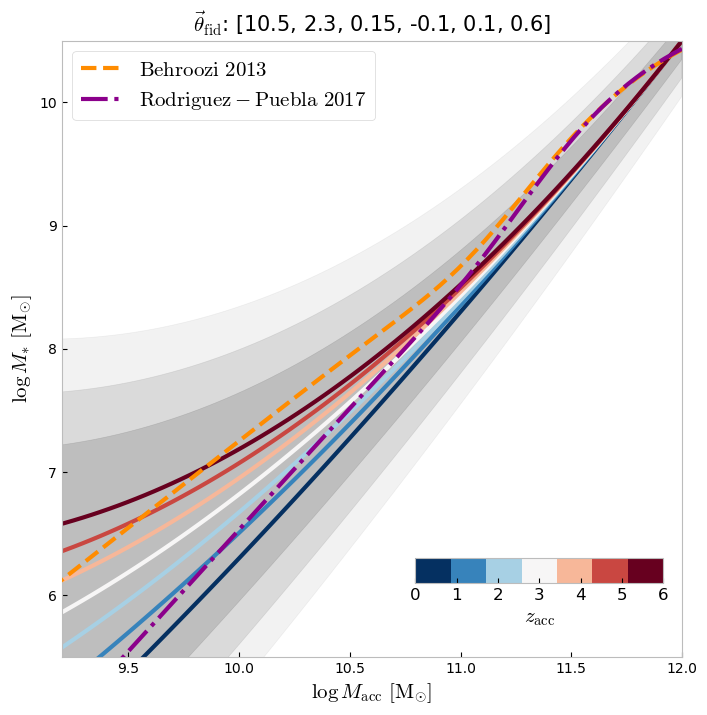

In [16]:
theta=[10.5, 2.3, 0.15, -0.1, 0.1, 0.6]

simple_plot(theta, model_label=f"{theta}", model_color="grey", mock=False, redshift=True, comparison=True, save_file="../../../paper_1/figures/realistic_infrence/SHMR.pdf")

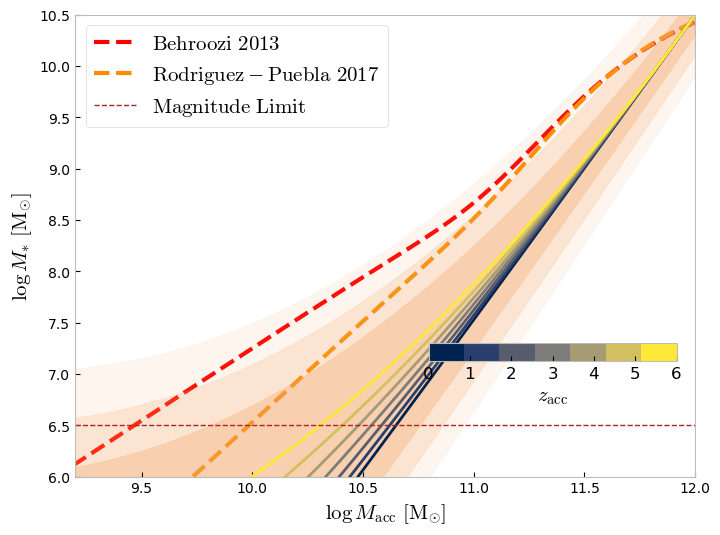

In [249]:
a1, a2 = simple_plot([10.5, 3, 0.2, -0.1, 0.03, 1.3], "sandybrown", mock=False, redshift=True, comparison=True)

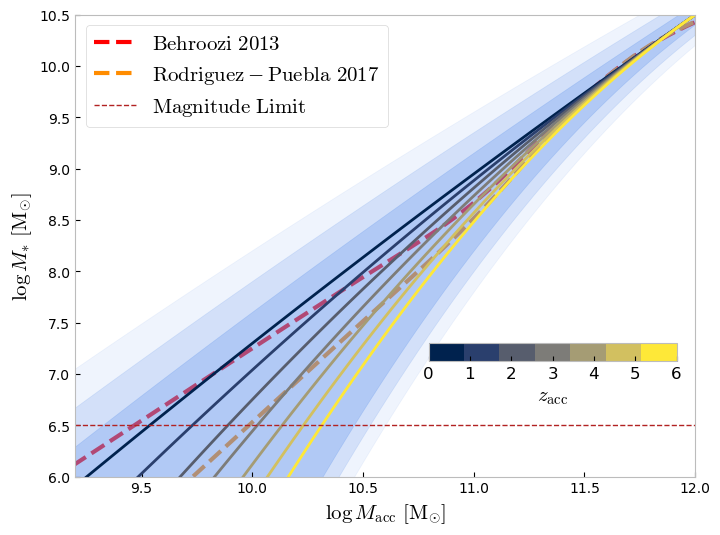

In [250]:
a1, a2 = simple_plot([10.5, 1.5, 0.1, -0.1, -0.05, 1.2], "cornflowerblue", mock=False, redshift=True, comparison=True)

In [32]:
beta = 0.2
red = np.random.uniform(0,5,100)
tau = -1

test = beta * (1+red)**tau

Text(0, 0.5, 'effective_beta')

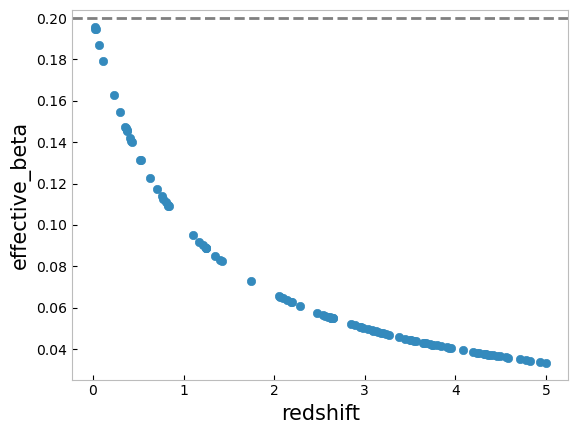

In [33]:
plt.scatter(red, test)
plt.axhline(beta, label="original value", ls="--", color="grey")
plt.xlabel("redshift")
plt.ylabel("effective_beta")

## the real data!

In [7]:
def mock_SHMR(theta_list, mocks, model_colors, model_labels, save_file=None):

    mass_example = np.vstack(np.load("../../../data/MW-analog/meta_data_psi4/models.npz")["mass"])
    red_example = np.vstack(np.load("../../../data/MW-analog/meta_data_psi4/models.npz")["redshift"])
    halo_masses = np.linspace(8,12,100) # just for the model
    
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 12), sharex='col', gridspec_kw={'width_ratios': [2, 1]})

    for i, (ax, theta, mock, model_color, model_label) in enumerate(zip(axs, theta_list, mocks, model_colors, model_labels)):
        mock_i = jsm_models.INIT_DATA(theta, mock)
        mock_i.get_stats(6.5)
        theta_det = theta[:2] + [0, 0] + theta[4:]

        #### the first column ####

        ax[0].set_title(model_label, fontsize=15, color=model_color)
        det = jsm_SHMR.general(theta_det, halo_masses, 0, Nsamples=1)
        ax[0].plot(halo_masses, det, color="black", label="$\\vec{\\theta}_{\mathrm{fid}}$", lw=2)

        sigma = theta[2] + theta[3] * (halo_masses - 12)
        sigma[sigma < 0] = 0.0

        ax[0].fill_between(halo_masses, det - sigma, det + sigma, color=model_color, alpha=0.6)
        ax[0].fill_between(halo_masses, det - 2 * sigma, det + 2 * sigma, color=model_color, alpha=0.4)
        ax[0].fill_between(halo_masses, det - 3 * sigma, det + 3 * sigma, color=model_color, alpha=0.2)
        #ax[0].plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses), lw=2, color="grey", ls="--", label="Rodriquez-Puebla et al. 2017")
        #ax[0].plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses), lw=2, color="black", ls="--", label="Rodriquez-Puebla et al. 2017")



        ax[0].scatter(mock_i.lgMh_flat, mock_i.lgMs_flat, marker="*", color="black", label="$\mathrm{Mock\ Survey}$", s=15, zorder=5)
        ax[0].axhline(6.5, ls="--", label="$\mathrm{Magnitude\ Limit}$", lw=1, color="firebrick")
        ax[0].set_ylabel("$\log M_{*}\ [\mathrm{M}_{\odot}]$", fontsize=15)
        ax[0].set_ylim(6.2, 10.5)
        ax[0].set_xlim(9.2, 12)

        ax[1].scatter(mock_i.stat.Nsat_perhost, mock_i.stat.maxmass, color="black", marker="*", s=10)
        ax[1].set_ylabel("$\mathrm{max}\ (\log M_{*})$ ", fontsize=15)
        ax[1].set_xticks(np.arange(1,12), np.arange(1,12))

        if i == 3:
            ax[0].legend(fontsize=15)
            ax[0].set_xlabel("$\log M_{\mathrm{acc}}\ [\mathrm{M}_{\odot}]$", fontsize=15)
            ax[1].set_xlabel("$N_{\mathrm{satellite}}$", fontsize=15)

    plt.tight_layout()

    if save_file != None:
        plt.savefig(save_file, bbox_inches='tight')

    plt.show()

            

In [ ]:
mock_1 = [10.5, 2.0, 0.2, 0, 0, 0]
mock_2 = [10.5, 2.5, 0.2, 0, 0, 0]
mock_3 = [10.5, 3.0, 0.2, 0, 0, 0]
mock_4 = [10.5, 3.5, 0.2, 0, 0, 0]

model_label_1 = "mock_1: [$\\alpha$="+str(mock_1[1])+", $\\sigma_0$="+str(mock_1[2])+ "]"
model_label_2 = "mock_2: [$\\alpha$="+str(mock_2[1])+", $\\sigma_0$="+str(mock_2[2])+ "]"
model_label_3 = "mock_3: [$\\alpha$="+str(mock_3[1])+", $\\sigma_0$="+str(mock_3[2])+ "]"
model_label_4 = "mock_4: [$\\alpha$="+str(mock_4[1])+", $\\sigma_0$="+str(mock_4[2])+ "]"


data_1 = "../../mcmc/Feature_Recovery/alpha_permutations/mock_1/mock_data.npy"
data_2 = "../../mcmc/Feature_Recovery/alpha_permutations/mock_2/mock_data.npy"
data_3 = "../../mcmc/Feature_Recovery/alpha_permutations/mock_3/mock_data.npy"
data_4 = "../../mcmc/Feature_Recovery/alpha_permutations/mock_4/mock_data.npy"

In [ ]:
mock_SHMR(theta_list=[mock_1, mock_2, mock_3, mock_4], mocks = [data_1, data_2, data_3, data_4], 
            model_colors=['orange', 'green', 'cornflowerblue', 'mediumpurple'], model_labels=[model_label_1, model_label_2, model_label_3, model_label_4], save_file="../../../paper_1/figures/appendix/alpha_SHMR.pdf")

In [ ]:
mock_1 = [10.5, 2.5, 0.2, 0, 0, 0]
mock_2 = [10.5, 2.5, 0.3, 0, 0, 0]
mock_3 = [10.5, 2.5, 0.4, 0, 0, 0]
mock_4 = [10.5, 2.5, 0.5, 0, 0, 0]

model_label_1 = "mock_1: [$\\alpha$="+str(mock_1[1])+", $\\sigma_0$="+str(mock_1[2])+"]"
model_label_2 = "mock_2: [$\\alpha$="+str(mock_2[1])+", $\\sigma_0$="+str(mock_2[2])+"]"
model_label_3 = "mock_3: [$\\alpha$="+str(mock_3[1])+", $\\sigma_0$="+str(mock_3[2])+"]"
model_label_4 = "mock_4: [$\\alpha$="+str(mock_4[1])+", $\\sigma_0$="+str(mock_4[2])+"]"


data_1 = "../../mcmc/Feature_Recovery/sigma_permutations/mock_1/mock_data.npy"
data_2 = "../../mcmc/Feature_Recovery/sigma_permutations/mock_2/mock_data.npy"
data_3 = "../../mcmc/Feature_Recovery/sigma_permutations/mock_3/mock_data.npy"
data_4 = "../../mcmc/Feature_Recovery/sigma_permutations/mock_4/mock_data.npy"

In [ ]:
mock_SHMR(theta_list=[mock_1, mock_2, mock_3, mock_4], mocks = [data_1, data_2, data_3, data_4], 
            model_colors=['orange', 'green', 'cornflowerblue', 'mediumpurple'], model_labels=[model_label_1, model_label_2, model_label_3, model_label_4], save_file="../../../paper_1/figures/appendix/sigma_SHMR.pdf")

In [8]:
mock_1 = [10.5, 2.5, 0.2, 0, 0.2, 0]
mock_2 = [10.5, 2.5, 0.2, 0, 0.1, 0]
mock_3 = [10.5, 2.5, 0.2, 0, 0., 0]
mock_4 = [10.5, 2.5, 0.2, 0, -0.1, 0]

model_label_1 = "mock_1: [$\\alpha$="+str(mock_1[1])+", $\\sigma_0$="+str(mock_1[2])+", $\\beta$="+str(mock_1[4]) + "]"
model_label_2 = "mock_2: [$\\alpha$="+str(mock_2[1])+", $\\sigma_0$="+str(mock_2[2])+", $\\beta$="+str(mock_2[4]) + "]"
model_label_3 = "mock_3: [$\\alpha$="+str(mock_3[1])+", $\\sigma_0$="+str(mock_3[2])+", $\\beta$="+str(mock_3[4]) + "]"
model_label_4 = "mock_4: [$\\alpha$="+str(mock_4[1])+", $\\sigma_0$="+str(mock_4[2])+", $\\beta$="+str(mock_4[4]) + "]"


data_1 = "../../mcmc/Feature_Recovery/beta_permutations/mock_1/mock_data.npy"
data_2 = "../../mcmc/Feature_Recovery/beta_permutations/mock_2/mock_data.npy"
data_3 = "../../mcmc/Feature_Recovery/beta_permutations/mock_3/mock_data.npy"
data_4 = "../../mcmc/Feature_Recovery/beta_permutations/mock_4/mock_data.npy"

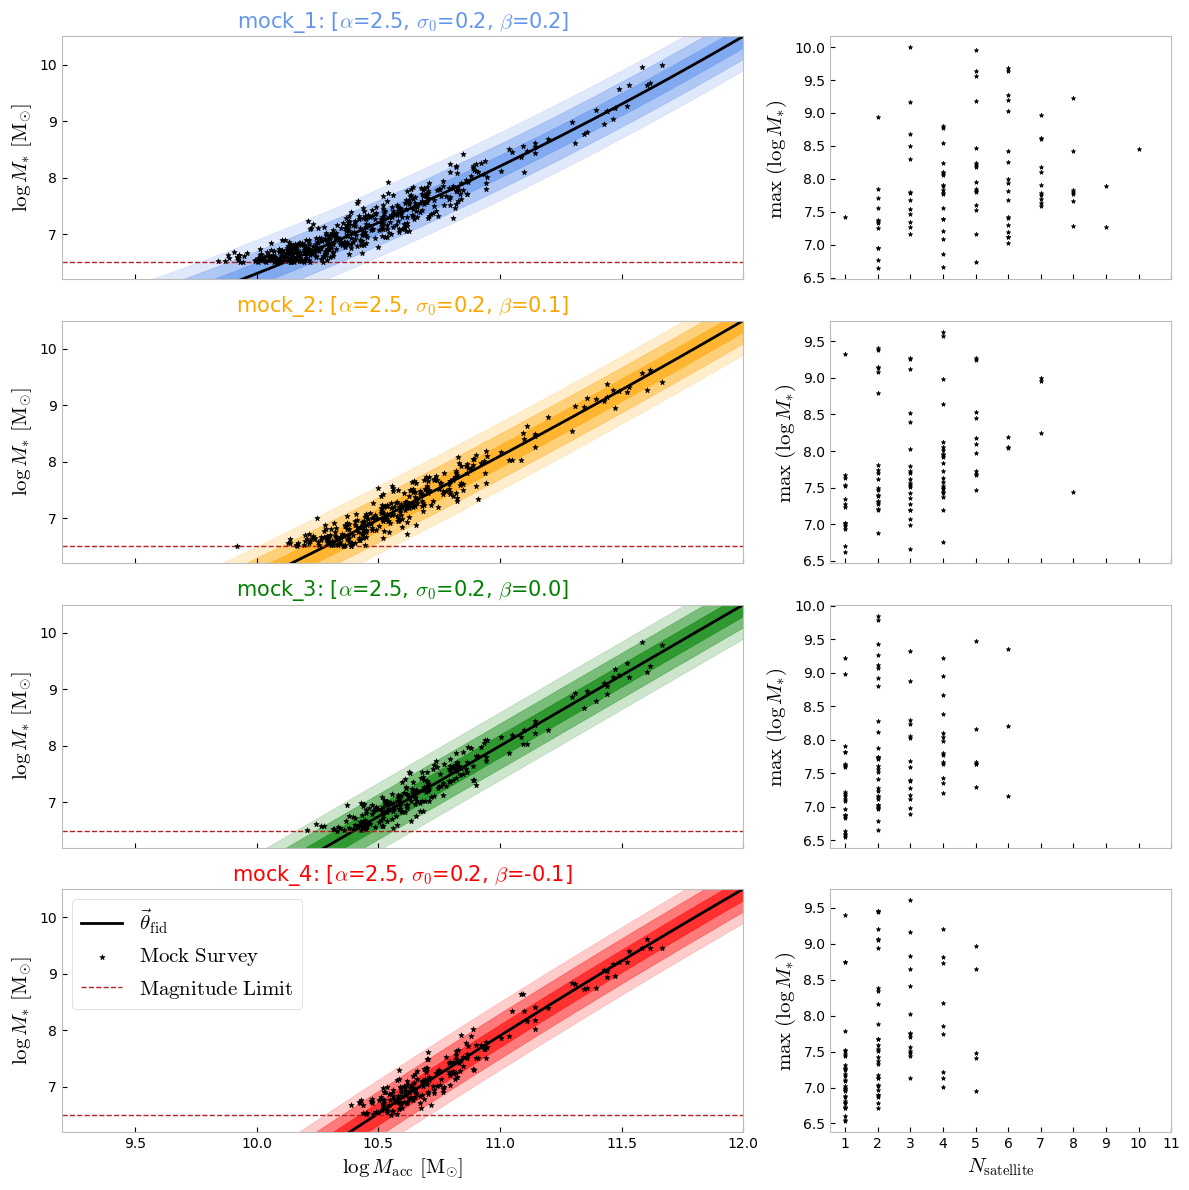

In [9]:
mock_SHMR(theta_list=[mock_1, mock_2, mock_3, mock_4], mocks = [data_1, data_2, data_3, data_4], 
            model_colors=['cornflowerblue', 'orange', 'green', 'red'], model_labels=[model_label_1, model_label_2, model_label_3, model_label_4])#, save_file="../../../paper_1/figures/SHMR_beta.pdf")

In [ ]:
# def multi_SHMR(theta_list, model_colors, model_labels, save_file=None):

#     fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 12), sharex='col', gridspec_kw={'width_ratios': [2, 1, 1]})

#     for i, (ax, theta, model_color, model_label) in enumerate(zip(axs, theta_list, model_colors, model_labels)):
#         stellar_example = jsm_SHMR.general(theta, mass_example, red_example, Nsamples=1)
#         theta_det = theta[:2] + [0, 0] + theta[4:]

#         #### the first column ####

#         if model_label != None:
#             ax[0].set_title(model_label, fontsize=15, color=model_color)

#         if i!=3:
#             det = jsm_SHMR.general(theta_det, halo_masses, 0, Nsamples=1)
#             ax[0].plot(halo_masses, det, color="black", label="deterministic", lw=2)

#             sigma = theta[2] + theta[3] * (halo_masses - 12)
#             sigma[sigma < 0] = 0.0

#             ax[0].fill_between(halo_masses, det - sigma, det + sigma, color=model_color, alpha=0.6)
#             ax[0].fill_between(halo_masses, det - 2 * sigma, det + 2 * sigma, color=model_color, alpha=0.4)
#             ax[0].fill_between(halo_masses, det - 3 * sigma, det + 3 * sigma, color=model_color, alpha=0.2)

#             SAGA_split = np.array_split(stellar_example, 100, axis=0)
#             mock_lgMh, mock_lgMs = mass_example[0:100, :], SAGA_split[0]
#             mass_cut = mock_lgMs > 6.5
#             ax[0].scatter(mock_lgMh[mass_cut], mock_lgMs[mass_cut], marker="*", color="black", label="mock survey", s=10, zorder=5)
#             ax[0].axhline(6.5, ls="--", label="magnitude limit", lw=1, color="peru")
            
#         else:
#             z_max = 6
#             z_array = np.arange(z_max+1)

#             sigma = theta[2] + theta[3] * (halo_masses - 12)
#             sigma[sigma < 0] = 0.0

#             dethi = jsm_SHMR.general(theta_det, halo_masses, z_max)
#             det0 = jsm_SHMR.general(theta_det, halo_masses, 0)

#             ax[0].fill_between(halo_masses, det0 - sigma, dethi + sigma, color=model_color, alpha=0.6)
#             ax[0].fill_between(halo_masses, det0 - 2 * sigma, dethi + 2 * sigma, color=model_color, alpha=0.4)
#             ax[0].fill_between(halo_masses, det0 - 3 * sigma, dethi + 3 * sigma, color=model_color, alpha=0.2)

#             cmap = plt.get_cmap('Reds_r')  # You can choose a different colormap
#             colors = cmap(np.linspace(0, 1, z_array.shape[0]))
#             custom_cmap = ListedColormap(colors)

#             for i in z_array:   
#                 ax[0].plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, i), lw=2, color=colors[i], Nsamples=1)
            
#             norm = plt.Normalize(0, z_max)
#             sm = ScalarMappable(cmap=custom_cmap, norm=norm)
#             sm.set_array([])

#             cax = ax[0].inset_axes([0.58, 0.3, 0.4, 0.04])
#             colorbar = fig.colorbar(sm, cax=cax, ticks=z_array, orientation='horizontal')
#             colorbar.ax.tick_params(axis='both', which='major', labelsize=12)
#             colorbar.set_label('z$_{\mathrm{acc}}$', fontsize=15)

#             SAGA_split = np.array_split(stellar_example, 100, axis=0)
#             mock_lgMh, mock_lgMs = mass_example[0:100, :], SAGA_split[0]
#             mass_cut = mock_lgMs > 6.5
#             ax[0].scatter(mock_lgMh[mass_cut], mock_lgMs[mass_cut], marker="*", color="black", label="mock survey", s=10, zorder=5)
#             ax[0].axhline(6.5, ls="--", label="magnitude limit", lw=1, color="peru")

#             ax[0].set_xlabel("M$_{\mathrm{acc}}$ [log (M$_\odot$)]", fontsize=15)
#             ax[0].set_xlim(9.3, 12)

#             ax[1].set_xlabel("N satellites", fontsize=15)
#             ax[1].set_xlim(-0.5, 20)

#             ax[2].set_xlabel("max( M$_{*}$ ) [log (M$_\odot$)]", fontsize=15)
#             ax[2].set_ylabel("CDF", fontsize=15)

#         if i == 0:
#             ax[0].legend(fontsize=15)


#         ax[0].set_ylabel("M$_{*}$ [log (M$_\odot$)]", fontsize=15)
#         ax[0].set_ylim(6, 10)

#         #### the second column ####

#         stat_instance = get_stats(mock_lgMs, 6.5)
#         ax[1].plot(np.arange(stat_instance.Pnsat.shape[0]), stat_instance.Pnsat, color="black", zorder=5)
#         ax[1].set_ylabel("PDF", fontsize=15)
#         ax[1].set_ylim(-0.01,0.4)

#         #### the third column ####

#         ax[2].plot(stat_instance.Msmax_sorted, stat_instance.ecdf_Msmax, color="black", zorder=5)
#         ax[2].set_ylabel("CDF", fontsize=15)

#         #### now for the permutations ####

#         # for mock in SAGA_split[1:99]:
#         #     stat_instance_i = get_stats(mock, 6.5)
#         #     ax[1].plot(np.arange(stat_instance_i.Pnsat.shape[0]), stat_instance_i.Pnsat, color=model_color, alpha=0.1, lw=1)
#         #     ax[2].plot(stat_instance_i.Msmax_sorted, stat_instance_i.ecdf_Msmax, color=model_color, alpha=0.1, lw=1)

#     plt.tight_layout()

#     if save_file != None:
#         plt.savefig(save_file, bbox_inches='tight')

#     plt.show()

#     #return stat_instance, mock_lgMh[mass_cut], mock_lgMs[mass_cut]


#### now for the model instance

In [ ]:
massdir = "/Users/jsmonzon/Research/data/MW-analog/meta_data_psi3/"

models = jsm_models.load_models(massdir, read_red=True) # need to change this for every run!

def forward(theta):
    models.convert_zacc(theta, jsm_SHMR.general)
    models.get_stats(min_mass=6.5)
    return models.stat.Pnsat, models.stat.Msmax, models.stat.ecdf_MsMax

In [ ]:
theta = [10.5, 2.0, 0.2, 0, 0, 0]
plabels = ["$M_{*}$", "$\\alpha$", "$\\sigma$"," $\\gamma$", "$\\beta$", "$\\tau$"]

In [ ]:
models_alpha = jsm_mcmc.single_chain("../../mcmc/paper_runs/model_A/alpha/mock_1/chain.h5", Nstack=1, Nburn=2000, Nthin=10, truths=theta, labels=plabels)
model_label_A = "model A: [$\\alpha$="+str(theta[1])+", $\\sigma_0$="+str(theta[2])+", $\\gamma$="+str(theta[3])+ ", $\\beta$="+str(theta[4]) + ", $\\tau$="+str(theta[5]) + "]"


In [ ]:
dataA = jsm_models.init_data(modelA, "../../mcmc/paper_runs/model_A/alpha/mock_1/mock_data.npy")

dataA.get_stats(min_mass=6.5, plot=False)
dataA.get_data_points(plot=False)

In [ ]:
def model_SHMR(theta, data, models, model_color, model_label, save_file=None):

    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), sharex='col', sharey='col', gridspec_kw={'width_ratios': [2, 1, 1]})

    stellar_example = jsm_SHMR.general(theta, mass_example, red_example)
    theta_det = theta[:2] + [0, 0] + theta[4:]

    SAGA_split = np.array_split(stellar_example, 100, axis=0)
    mass_cut = data.lgMs > 6.5


    #### the 0,0 panel ####

    axs[0, 0].set_title(model_label, fontsize=15, color=model_color)

    det = jsm_SHMR.general(theta_det, halo_masses, 0)
    axs[0, 0].plot(halo_masses, det, color="black", label="deterministic", lw=2)
    axs[0, 0].scatter(data.lgMh[mass_cut], data.lgMs[mass_cut], marker="*", color="black", label="mock survey", s=10, zorder=5)
    axs[0, 0].axhline(6.5, ls="--", label="magnitude limit", lw=1, color="peru")
    axs[0, 0].legend(fontsize=12)
    axs[0, 0].set_ylabel("M$_{*}$ [log (M$_\odot$)]", fontsize=15)


    sigma = theta[2] + theta[3] * (halo_masses - 12)

    axs[0, 0].fill_between(halo_masses, det - sigma, det + sigma, color=model_color, alpha=0.6)
    axs[0, 0].fill_between(halo_masses, det - 2 * sigma, det + 2 * sigma, color=model_color, alpha=0.4)
    axs[0, 0].fill_between(halo_masses, det - 3 * sigma, det + 3 * sigma, color=model_color, alpha=0.2)
    axs[0, 0].set_ylim(6, 10)


    ### the 0,1 panel ###

    axs[0, 1].plot(np.arange(data.stat.Pnsat.shape[0]), data.stat.Pnsat, color="black", zorder=5)
    axs[0, 1].set_ylabel("PDF", fontsize=15)

    ### the 0,2 panel ###

    axs[0, 2].plot(data.stat.Msmax, data.stat.ecdf_MsMax, color="black", zorder=5)
    axs[0, 2].set_ylabel("CDF", fontsize=15)

    #### the 1,0 panel ####

    axs[1, 0].scatter(data.lgMh[mass_cut], data.lgMs[mass_cut], marker="*", color="black", s=10, zorder=5)
    axs[1, 0].axhline(6.5, ls="--", lw=1, color="peru")

    axs[1, 0].set_xlabel("M$_{\mathrm{acc}}$ [log (M$_\odot$)]", fontsize=15)
    axs[1, 0].set_xlim(9.3, 12)

    axs[1, 0].set_ylabel("M$_{*}$ [log (M$_\odot$)]", fontsize=15)
    axs[1, 0].set_ylim(6, 10)


    #### the 1,1 panel ####

    axs[1, 1].plot(np.arange(data.stat.Pnsat.shape[0]), data.stat.Pnsat, color="black", zorder=5)
    axs[1, 1].set_xlabel("N satellites", fontsize=15)
    axs[1, 1].set_ylabel("PDF", fontsize=15)
    axs[1, 1].set_xlim(-0.5, 20)
    axs[1, 1].set_ylim(-0.01,0.4)

    #### the 1,2 panel ####

    axs[1, 2].plot(data.stat.Msmax, data.stat.ecdf_MsMax, color="black", zorder=5)
    axs[1, 2].set_xlabel("max( M$_{*}$ ) [log (M$_\odot$)]", fontsize=15)
    axs[1, 2].set_ylabel("CDF", fontsize=15)
    #### the model iterations ####


    for k, theta in enumerate(models):
        theta_i = theta.tolist()
        hmm1, hmm2, hmm3 = forward(theta_i)
        axs[1, 1].plot(np.arange(hmm1.shape[0]), hmm1, color="grey", alpha=0.3, lw=1)
        axs[1, 2].plot(hmm2, hmm3, color="grey", alpha=0.3, lw=1)

        theta_det = theta_i[:2] + [0, 0] + theta_i[4:]
        if k==0:
            axs[1, 0].plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, 0), color="grey", label="model instances", alpha=0.3, lw=1)
        else:
            axs[1, 0].plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, 0), color="grey", alpha=0.3, lw=1)
        axs[1, 0].legend(fontsize=12)

    #### the data permutations ####

    for mock in SAGA_split[1:99]:
        stat_instance_i = get_stats(mock, 6.5)
        axs[0, 1].plot(np.arange(stat_instance_i.Pnsat.shape[0]), stat_instance_i.Pnsat, color=model_color, alpha=0.1, lw=1)
        axs[0, 2].plot(stat_instance_i.Msmax, stat_instance_i.ecdf_MsMax, color=model_color, alpha=0.1, lw=1)

    plt.tight_layout()

    if save_file != None:
        plt.savefig(save_file, bbox_inches='tight')
    
plt.show()




In [ ]:
model_SHMR(theta, dataA, models_alpha.end, "darkcyan", model_label_A, save_file="../../../paper_1/figures/SHMR_model.pdf")

useful functions for plotting!

In [ ]:
# def multi_SHMR(theta_list, model_colors, model_labels, save_file=None):

#     fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 12), sharex='col', gridspec_kw={'width_ratios': [2, 1, 1]})

#     for i, (ax, theta, model_color, model_label) in enumerate(zip(axs, theta_list, model_colors, model_labels)):
#         stellar_example = jsm_SHMR.general(theta, mass_example, red_example, Nsamples=1)
#         theta_det = theta[:2] + [0, 0] + theta[4:]

#         #### the first column ####

#         if model_label != None:
#             ax[0].set_title(model_label, fontsize=15, color=model_color)

#         if i!=3:
#             det = jsm_SHMR.general(theta_det, halo_masses, 0, Nsamples=1)
#             ax[0].plot(halo_masses, det, color="black", label="deterministic", lw=2)

#             sigma = theta[2] + theta[3] * (halo_masses - 12)
#             sigma[sigma < 0] = 0.0

#             ax[0].fill_between(halo_masses, det - sigma, det + sigma, color=model_color, alpha=0.6)
#             ax[0].fill_between(halo_masses, det - 2 * sigma, det + 2 * sigma, color=model_color, alpha=0.4)
#             ax[0].fill_between(halo_masses, det - 3 * sigma, det + 3 * sigma, color=model_color, alpha=0.2)

#             SAGA_split = np.array_split(stellar_example, 100, axis=0)
#             mock_lgMh, mock_lgMs = mass_example[0:100, :], SAGA_split[0]
#             mass_cut = mock_lgMs > 6.5
#             ax[0].scatter(mock_lgMh[mass_cut], mock_lgMs[mass_cut], marker="*", color="black", label="mock survey", s=10, zorder=5)
#             ax[0].axhline(6.5, ls="--", label="magnitude limit", lw=1, color="peru")
            
#         else:
#             z_max = 6
#             z_array = np.arange(z_max+1)

#             sigma = theta[2] + theta[3] * (halo_masses - 12)
#             sigma[sigma < 0] = 0.0

#             dethi = jsm_SHMR.general(theta_det, halo_masses, z_max)
#             det0 = jsm_SHMR.general(theta_det, halo_masses, 0)

#             ax[0].fill_between(halo_masses, det0 - sigma, dethi + sigma, color=model_color, alpha=0.6)
#             ax[0].fill_between(halo_masses, det0 - 2 * sigma, dethi + 2 * sigma, color=model_color, alpha=0.4)
#             ax[0].fill_between(halo_masses, det0 - 3 * sigma, dethi + 3 * sigma, color=model_color, alpha=0.2)

#             cmap = plt.get_cmap('Reds_r')  # You can choose a different colormap
#             colors = cmap(np.linspace(0, 1, z_array.shape[0]))
#             custom_cmap = ListedColormap(colors)

#             for i in z_array:   
#                 ax[0].plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, i), lw=2, color=colors[i], Nsamples=1)
            
#             norm = plt.Normalize(0, z_max)
#             sm = ScalarMappable(cmap=custom_cmap, norm=norm)
#             sm.set_array([])

#             cax = ax[0].inset_axes([0.58, 0.3, 0.4, 0.04])
#             colorbar = fig.colorbar(sm, cax=cax, ticks=z_array, orientation='horizontal')
#             colorbar.ax.tick_params(axis='both', which='major', labelsize=12)
#             colorbar.set_label('z$_{\mathrm{acc}}$', fontsize=15)

#             SAGA_split = np.array_split(stellar_example, 100, axis=0)
#             mock_lgMh, mock_lgMs = mass_example[0:100, :], SAGA_split[0]
#             mass_cut = mock_lgMs > 6.5
#             ax[0].scatter(mock_lgMh[mass_cut], mock_lgMs[mass_cut], marker="*", color="black", label="mock survey", s=10, zorder=5)
#             ax[0].axhline(6.5, ls="--", label="magnitude limit", lw=1, color="peru")

#             ax[0].set_xlabel("M$_{\mathrm{acc}}$ [log (M$_\odot$)]", fontsize=15)
#             ax[0].set_xlim(9.3, 12)

#             ax[1].set_xlabel("N satellites", fontsize=15)
#             ax[1].set_xlim(-0.5, 20)

#             ax[2].set_xlabel("max( M$_{*}$ ) [log (M$_\odot$)]", fontsize=15)
#             ax[2].set_ylabel("CDF", fontsize=15)

#         if i == 0:
#             ax[0].legend(fontsize=15)


#         ax[0].set_ylabel("M$_{*}$ [log (M$_\odot$)]", fontsize=15)
#         ax[0].set_ylim(6, 10)

#         #### the second column ####

#         stat_instance = get_stats(mock_lgMs, 6.5)
#         ax[1].plot(np.arange(stat_instance.Pnsat.shape[0]), stat_instance.Pnsat, color="black", zorder=5)
#         ax[1].set_ylabel("PDF", fontsize=15)
#         ax[1].set_ylim(-0.01,0.4)

#         #### the third column ####

#         ax[2].plot(stat_instance.Msmax_sorted, stat_instance.ecdf_Msmax, color="black", zorder=5)
#         ax[2].set_ylabel("CDF", fontsize=15)

#         #### now for the permutations ####

#         # for mock in SAGA_split[1:99]:
#         #     stat_instance_i = get_stats(mock, 6.5)
#         #     ax[1].plot(np.arange(stat_instance_i.Pnsat.shape[0]), stat_instance_i.Pnsat, color=model_color, alpha=0.1, lw=1)
#         #     ax[2].plot(stat_instance_i.Msmax_sorted, stat_instance_i.ecdf_Msmax, color=model_color, alpha=0.1, lw=1)

#     plt.tight_layout()

#     if save_file != None:
#         plt.savefig(save_file, bbox_inches='tight')

#     plt.show()

#     #return stat_instance, mock_lgMh[mass_cut], mock_lgMs[mass_cut]


In [ ]:
# def SHMR_PLOT(theta, model_label=None, mock=None, redshift=False, model_color="lightcoral", legend=False, save_file=None):

#     stellar_example = jsm_SHMR.general(theta, mass_example, red_example)
#     theta_det = theta[:2] + [0, 0] + theta[4:]

#     flat_H = mass_example.flatten()
#     flat_S = stellar_example.flatten()
#     nanmask = ~np.isnan(flat_H)

#     fig, ax = plt.subplots(figsize=(8, 6))

#     # for i, Ms in enumerate(stellar_example):
#     #     plt.plot(mass_example[i], Ms, alpha=0.01, color="grey")

#     if model_label!=None:
#         ax.set_title(model_label, fontsize=15)

#     ax.axhline(6.5, ls="--", label="magnitude limit", lw=1, color="peru")
#     ax.legend(fontsize=12)
#     ax.set_ylabel("M$_{*}$ [log (M$_\odot$)]", fontsize=15)

#     det8 = jsm_SHMR.general(theta_det, halo_masses, 8)
#     det0 = jsm_SHMR.general(theta_det, halo_masses, 0)

#     sigma = theta[2] + theta[3] * (halo_masses - 12)

#     ax.fill_between(halo_masses, det0 - sigma, det8 + sigma, color=model_color, alpha=0.6)
#     ax.fill_between(halo_masses, det0 - 2 * sigma, det8 + 2 * sigma, color=model_color, alpha=0.4)
#     ax.fill_between(halo_masses, det0 - 3 * sigma, det8 + 3 * sigma, color=model_color, alpha=0.2)

#     if redshift==True:
#         z_array = np.arange(9)

#         cmap = plt.get_cmap('Reds_r')  # You can choose a different colormap
#         colors = cmap(np.linspace(0, 1, z_array.shape[0]))
#         custom_cmap = ListedColormap(colors)

#         for i in z_array:   
#             ax.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, i), lw=2, color=colors[i])
        
#         norm = plt.Normalize(0, 8)
#         sm = ScalarMappable(cmap=custom_cmap, norm=norm)
#         sm.set_array([])

#         cax = ax.inset_axes([0.55, 0.25, 0.4, 0.04])
#         colorbar = fig.colorbar(sm, cax=cax, ticks=z_array, orientation='horizontal')
#         colorbar.ax.tick_params(axis='both', which='major', labelsize=12)
#         colorbar.set_label('z$_{\mathrm{acc}}$', fontsize=15)

#     if mock==True:
#         mock_index = np.random.randint(0,10000,100)
#         mock_lgMh, mock_lgMs = mass_example[mock_index, :], stellar_example[mock_index, :]
#         mass_cut = mock_lgMs > 6.5
#         ax.scatter(mock_lgMh[mass_cut], mock_lgMs[mass_cut], marker="*", s=9, color="black", label="Mock Survey", zorder=5)

#     ax.set_xlabel("log m$_{\mathrm{acc}}$ [M$_\odot$]", fontsize=15)
#     ax.set_xlim(9.3, 12)
#     ax.set_ylim(6, 10)
#     if legend==True:
#         ax.legend(fontsize=15)

#     if save_file!=None:
#         ax.savefig(save_file)

#     plt.show()

In [ ]:
# SHMR_PLOT([10.5, 1.9, 0.2, -0.05, 0.01, 1.2], redshift=True, mock=True)

In [ ]:
# def plot_SHMR_dist(theta, theta_det, model_label, save_file=None):

#     stellar_example = jsm_SHMR.general(theta, mass_example, red_example)

#     flat_H = mass_example.flatten()
#     flat_S = stellar_example.flatten()
#     nanmask = ~np.isnan(flat_H)

#     plt.figure(figsize=(8, 6))
#     plt.title(model_label, fontsize=15)
#     plt.hist2d(flat_H[nanmask], flat_S[nanmask], bins=(binH, binS), norm=PowerNorm(gamma=0.15), cmap="Blues")
#     plt.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses,0), color="navy", label="Deterministic Relation", lw=2)
#     plt.plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses, 0), color="red", ls="--", label="Behroozi 2013", lw=2)
#     plt.plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses, 0), color="orange", ls="--", label="Rodriguez-Puebla 2017", lw=2)
#     plt.ylabel("log m$_{*}$ [M$_\odot$]", fontsize=15)
#     plt.xlabel("log m$_{\mathrm{acc}}$ [M$_\odot$]", fontsize=15)
#     plt.yticks(fontsize=12)
#     plt.xticks(fontsize=12)
#     plt.grid(False)

#     plt.legend(fontsize=15)

#     if save_file !=None:
#         plt.savefig("../../SatGen/mcmc/figures/paper/"+save_file)
#     plt.show()
# def plot_contour(theta, theta_det, model_label, redshift=False, legend=False, save_file=None):

#     halo_masses = np.linspace(8,12,100) # just for the plotting

#     stellar_example = jsm_SHMR.general(theta, mass_example, red_example)

#     flat_H = mass_example.flatten()
#     flat_S = stellar_example.flatten()
#     nanmask = ~np.isnan(flat_H)

#     hist, xedges, yedges = np.histogram2d(flat_H[nanmask], flat_S[nanmask], bins=(binH, binS))

#     fig, ax = plt.subplots(figsize=(8, 6))
#     ax.set_title(model_label, fontsize=15)

#     levels = np.linspace(0, hist.max(), 10)  # Adjust the number of levels as needed
#     contour = ax.contour(xedges[:-1], yedges[:-1], hist.T, [0.5], colors="cornflowerblue", label="scatter")
#     ax.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses,0), color="navy", label="Deterministic Relation", lw=2)
#     plt.plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses, 0), color="red", ls="--", label="Behroozi 2013", lw=2)
#     plt.plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses, 0), color="orange", ls="--", label="Rodriguez-Puebla 2017", lw=2)

#     if redshift==True:
#         z_array = np.arange(10)

#         cmap = plt.get_cmap('plasma')  # You can choose a different colormap
#         colors = cmap(np.linspace(0, 1, z_array.shape[0]))
#         custom_cmap = ListedColormap(colors)

#         for i in z_array:   
#             ax.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, i), lw=2, color=colors[i])
        
#         norm = plt.Normalize(0, 9)
#         sm = ScalarMappable(cmap=custom_cmap, norm=norm)
#         sm.set_array([])

#         cax = ax.inset_axes([0.55, 0.15,0.4, 0.04])
#         colorbar = fig.colorbar(sm, cax=cax, ticks=z_array, orientation='horizontal')
#         colorbar.ax.tick_params(axis='both', which='major', labelsize=12)
#         colorbar.set_label('z$_{\mathrm{acc}}$', fontsize=15)

#     plt.ylabel("log m$_{*}$ [M$_\odot$]", fontsize=15)
#     plt.xlabel("log m$_{\mathrm{acc}}$ [M$_\odot$]", fontsize=15)
#     plt.xlim(8, 11.7)
#     plt.ylim(2.3, 10.5)
#     if legend==True:
#         plt.legend(fontsize=15)

#     if save_file!=None:
#         plt.savefig(save_file)

#     plt.show()
# def SHMR_PLOT(theta, model_label=None, mock=None, redshift=False, hist2d=True, contour=True, comparison=False, legend=False, save_file=None):

#     stellar_example = jsm_SHMR.general(theta, mass_example, red_example)
#     theta_det = theta[:2] + [0, 0] + theta[4:]

#     flat_H = mass_example.flatten()
#     flat_S = stellar_example.flatten()
#     nanmask = ~np.isnan(flat_H)

#     hist, xedges, yedges = np.histogram2d(flat_H[nanmask], flat_S[nanmask], bins=(binH, binS))

#     fig, ax = plt.subplots(figsize=(8, 6))

#     for i, Ms in enumerate(stellar_example):
#         plt.plot(mass_example[i], Ms, alpha=0.01, color="grey")

#     if model_label!=None:
#         ax.set_title(model_label, fontsize=15)

#     if hist2d==True:
#         plt.hist2d(flat_H[nanmask], flat_S[nanmask], bins=(binH, binS), cmap="Blues")

#     if contour==True:
#         levels = np.linspace(0, hist.max(), 10)  # Adjust the number of levels as needed
#         contour = ax.contour(xedges[:-1], yedges[:-1], hist.T, [0.5], colors="cornflowerblue", label="scatter")
        
#     if comparison==True:
#         ax.plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses, 0), color="red", ls="--", label="Behroozi 2013", lw=2)
#         ax.plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses, 0), color="orange", ls="--", label="Rodriguez-Puebla 2017", lw=2)

#     ax.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses,0), color="navy", label="Deterministic Relation", lw=2)

#     if redshift==True:
#         z_array = np.arange(10)

#         cmap = plt.get_cmap('plasma')  # You can choose a different colormap
#         colors = cmap(np.linspace(0, 1, z_array.shape[0]))
#         custom_cmap = ListedColormap(colors)

#         for i in z_array:   
#             ax.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, i), lw=2, color=colors[i])
        
#         norm = plt.Normalize(0, 9)
#         sm = ScalarMappable(cmap=custom_cmap, norm=norm)
#         sm.set_array([])

#         cax = ax.inset_axes([0.55, 0.15,0.4, 0.04])
#         colorbar = fig.colorbar(sm, cax=cax, ticks=z_array, orientation='horizontal')
#         colorbar.ax.tick_params(axis='both', which='major', labelsize=12)
#         colorbar.set_label('z$_{\mathrm{acc}}$', fontsize=15)

#     if mock==True:
#         mock_index = np.random.randint(0,10000,100)
#         mock_lgMh, mock_lgMs = mass_example[mock_index, :], stellar_example[mock_index, :]
#         mass_cut = mock_lgMs > 6.5
#         ax.scatter(mock_lgMh[mass_cut], mock_lgMs[mass_cut], marker="*", s=9, color="black", label="Mock Survey")

#     ax.set_ylabel("log m$_{*}$ [M$_\odot$]", fontsize=15)
#     ax.set_xlabel("log m$_{\mathrm{acc}}$ [M$_\odot$]", fontsize=15)
#     ax.set_xlim(8, 11.7)
#     ax.set_ylim(4, 10)
#     if legend==True:
#         ax.legend(fontsize=15)

#     if save_file!=None:
#         ax.savefig(save_file)

#     plt.show()
# def new_SHMR(theta, model_color, model_label=None, mock=True, redshift=False, comparison=False, legend=False, save_file=None):

#     stellar_example = jsm_SHMR.general(theta, mass_example, red_example)
#     theta_det = theta[:2] + [0, 0] + theta[4:]

#     fig, ax = plt.subplots(figsize=(8, 6))

#     if model_label!=None:
#         ax.set_title(model_label, fontsize=15)

#     if comparison==True:
#         ax.plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses, 0), color="red", ls="--", label="Behroozi 2013", lw=2)
#         ax.plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses, 0), color="orange", ls="--", label="Rodriguez-Puebla 2017", lw=2)

#     det = jsm_SHMR.general(theta_det, halo_masses, 0)
#     ax.plot(halo_masses, det, color=model_color, label="determinisitic", lw=2)

#     sigma = theta[2] + theta[3]*(halo_masses-12)
    
#     ax.fill_between(halo_masses, det - sigma, det + sigma, color=model_color, alpha=0.5) 
#     ax.fill_between(halo_masses, det - 2*sigma, det + 2*sigma, color=model_color, alpha=0.3) 
#     ax.fill_between(halo_masses, det - 3*sigma, det + 3*sigma, color=model_color, alpha=0.1) 

#     if redshift==True:
#         z_array = np.arange(10)

#         cmap = plt.get_cmap('viridis')  # You can choose a different colormap
#         colors = cmap(np.linspace(0, 1, z_array.shape[0]))
#         custom_cmap = ListedColormap(colors)

#         for i in z_array:   
#             ax.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, i), lw=2, color=colors[i])
        
#         norm = plt.Normalize(0, 9)
#         sm = ScalarMappable(cmap=custom_cmap, norm=norm)
#         sm.set_array([])

#         cax = ax.inset_axes([0.55, 0.15,0.4, 0.04])
#         colorbar = fig.colorbar(sm, cax=cax, ticks=z_array, orientation='horizontal')
#         colorbar.ax.tick_params(axis='both', which='major', labelsize=12)
#         colorbar.set_label('z$_{\mathrm{acc}}$', fontsize=15)

#     if mock==True:
#         mock_index = np.random.randint(0,10000,100)
#         mock_lgMh, mock_lgMs = mass_example[mock_index, :], stellar_example[mock_index, :]
#         mass_cut = mock_lgMs > 6.5
#         ax.axhline(6.5, ls="--", label="magnitude limit", lw=1, color="grey")
#         ax.scatter(mock_lgMh[mass_cut], mock_lgMs[mass_cut], marker="*", color="black", label="mock survey", zorder=5)

#     ax.set_ylabel("log m$_{*}$ [M$_\odot$]", fontsize=15)
#     ax.set_xlabel("log m$_{\mathrm{acc}}$ [M$_\odot$]", fontsize=15)
#     ax.set_xlim(8.5, 11.8)
#     ax.set_ylim(5.5, 10)
#     if legend==True:
#         ax.legend(fontsize=15)

#     if save_file!=None:
#         ax.savefig(save_file)

#     plt.show()
# theta = [10.5, 1.9, 0.2, 0, 0, 0]

# new_SHMR(theta, model_label="test", model_color="olivedrab", mock=True, legend=True)
### new figures for the paper
# def multi_SHMR(theta_list, model_colors, model_labels, mock=True, comparison=False, save_file=None):

#     fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 15), sharey=True, sharex=True)

#     for i, (ax, theta, model_color, model_label) in enumerate(zip(axs, theta_list, model_colors, model_labels)):
#         stellar_example = jsm_SHMR.general(theta, mass_example, red_example)
#         theta_det = theta[:2] + [0, 0] + theta[4:]

#         if model_label != None:
#             ax.set_title(model_label, fontsize=15, color=model_color)

#         if comparison == True:
#             ax.plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses, 0), color="red", ls="--", label="Behroozi 2013", lw=2)
#             ax.plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses, 0), color="orange", ls="--", label="Rodriguez-Puebla 2017", lw=2)

#         det = jsm_SHMR.general(theta_det, halo_masses, 0)
#         ax.plot(halo_masses, det, color="black", label="deterministic", lw=2)

#         sigma = theta[2] + theta[3] * (halo_masses - 12)

#         ax.fill_between(halo_masses, det - sigma, det + sigma, color=model_color, alpha=0.5)
#         ax.fill_between(halo_masses, det - 2 * sigma, det + 2 * sigma, color=model_color, alpha=0.3)
#         ax.fill_between(halo_masses, det - 3 * sigma, det + 3 * sigma, color=model_color, alpha=0.1)

#         if mock == True:
#             mock_index = np.random.randint(0, 10000, 100)
#             mock_lgMh, mock_lgMs = mass_example[mock_index, :], stellar_example[mock_index, :]
#             mass_cut = mock_lgMs > 6.5
#             ax.axhline(6.5, ls="--", label="magnitude limit", lw=1, color="grey")
#             ax.scatter(mock_lgMh[mass_cut], mock_lgMs[mass_cut], marker="*", color="black", label="mock survey", s=20, zorder=5)

#         if i == 2:
#             ax.set_xlabel("log m$_{\mathrm{acc}}$ [M$_\odot$]", fontsize=15)
#             ax.set_xlim(9.3, 12)
#         if i == 0:
#             ax.legend(fontsize=15)


#         ax.set_ylabel("log m$_{*}$ [M$_\odot$]", fontsize=15)
#         ax.set_ylim(6, 10)

#     plt.tight_layout()

#     if save_file != None:
#         plt.savefig(save_file)

#     plt.show()


# def plot_twostat(data, modelz, model_label, save_file=None, model=None):

#     fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), gridspec_kw={'width_ratios': [2, 1, 1]})
#     axs[0].set_title(model_label, fontsize=15, color="darkcyan")

#     mass_cut = data.lgMs > 6.5

#     axs[0].scatter(data.lgMh[mass_cut], data.lgMs[mass_cut], marker="*", color="black", label="mock survey", s=10, zorder=5)
#     axs[0].axhline(6.5, ls="--", label="magnitude limit", lw=1, color="grey")
#     axs[0].set_ylim(6, 10)
#     axs[0].set_xlim(9.3, 12)

#     axs[0].set_xlabel("M$_{\mathrm{acc}}$ [log (M$_\odot$)]", fontsize=15)
#     axs[0].set_ylabel("M$_{*}$ [log (M$_\odot$)]", fontsize=15)
#     axs[0].legend(fontsize=12)


#     # Plot the first graph on the left subplot

#     for theta in modelz:
#         theta_i = theta.tolist()
#         hmm1, hmm2, hmm3 = forward(theta_i)
#         axs[1].plot(np.arange(hmm1.shape[0]), hmm1, color="grey", alpha=0.3, lw=1)
#         axs[2].plot(hmm2, hmm3, color="grey", alpha=0.3, lw=1)

#         theta_det = theta_i[:2] + [0, 0] + theta_i[4:]
#         axs[0].plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, 0), color="grey", alpha=0.3, lw=1)

#     axs[1].set_xlabel("N satellites", fontsize=15)
#     axs[1].set_ylabel("PDF", fontsize=15)
#     axs[1].set_xlim(0, 25)
#     axs[1].set_ylim(-0.01,0.35)

#     # Plot the second graph on the right subplot

#     axs[1].plot(np.arange(data.stat.Pnsat.shape[0]), data.stat.Pnsat, color="black", zorder=5)
#     axs[2].plot(data.stat.Msmax, data.stat.ecdf_MsMax, color="black", zorder=5)


#     axs[2].set_xlabel("max( M$_{*}$ ) [log (M$_\odot$)]", fontsize=15)
#     axs[2].set_ylabel("CDF", fontsize=15)

#     # Adjust layout to prevent clipping of labels
#     plt.tight_layout()
#     # Show the plot

#     if save_file !=None:
#         plt.savefig(save_file, bbox_inches="tight")

#     plt.show()